In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
from sklearn.neighbors import KNeighborsClassifier
from google.colab import files
from math import *
import time
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


In [2]:
from google.colab import files

## Faça upload de um dataset com nome insurance (baixável em https://www.kaggle.com/mirichoi0218/insurance)
uploaded = files.upload()

Saving winequality.csv to winequality.csv


## Explorando um pouco o dataset

In [3]:
wine = pd.read_csv('/content/winequality.csv')
wine.head()

Unnamed: 0  fixed acidity  volatile acidity  ...  alcohol  quality  wine_is_red
0           0            5.9              0.61  ...     11.1        6            1
1           1            8.2              1.00  ...      9.0        6            1
2           2            6.4              0.24  ...     10.5        6            0
3           3            6.6              0.23  ...     10.0        6            0
4           4            7.2              0.24  ...     10.1        6            0

[5 rows x 14 columns]

À primeira vista parece que o sistema que queremos é um que seja capaz de prever que tipo de vinho temos ao final (vermelho ou nao) a partir de diversas características. Vamos entender melhor o dataset

In [4]:
quality = wine['quality']

In [5]:
wine.describe()

Unnamed: 0  fixed acidity  ...      quality  wine_is_red
count  6497.000000    6497.000000  ...  6497.000000  6497.000000
mean   3248.000000       7.215307  ...     5.818378     0.246114
std    1875.666681       1.296434  ...     0.873255     0.430779
min       0.000000       3.800000  ...     3.000000     0.000000
25%    1624.000000       6.400000  ...     5.000000     0.000000
50%    3248.000000       7.000000  ...     6.000000     0.000000
75%    4872.000000       7.700000  ...     6.000000     0.000000
max    6496.000000      15.900000  ...     9.000000     1.000000

[8 rows x 14 columns]

In [6]:
wine['quality'].unique()

array([6, 7, 5, 4, 8, 3, 9])

In [7]:
wine['wine_is_red'].unique()

array([1, 0])

Certo, então a priori parece possível a previsão de duas características do vinho. Qualidade, pois há sete classes, e se é vermelho ou não. Nesse caso vamos começar tentando prever se o vinho é vermelho. Abaixo eu dropei a coluna Unnamed (pois é irrelevante para a nossa análise e portanto detrimental). Usando a técnica PCA também reduzi o modelo para duas dimensões para ver se de fato há uma divisão clara espacial (do período anterior foi visto que os datasets podem estar distribuídos das mais diversas maneiras).

In [8]:
def scales(df):
  df.columns
  notObject = df.columns[df.dtypes!='object']
  #df[notObject]
  for name in notObject:
    df[name] = (df[name]-df[name].min())/(df[name].max()-df[name].min())
  return df


In [9]:
wine = wine.drop(columns = ['Unnamed: 0'])
wine.head()

fixed acidity  volatile acidity  citric acid  ...  alcohol  quality  wine_is_red
0            5.9              0.61         0.08  ...     11.1        6            1
1            8.2              1.00         0.09  ...      9.0        6            1
2            6.4              0.24         0.49  ...     10.5        6            0
3            6.6              0.23         0.26  ...     10.0        6            0
4            7.2              0.24         0.29  ...     10.1        6            0

[5 rows x 13 columns]

In [10]:
wineN = wine.drop(columns = ['wine_is_red'])

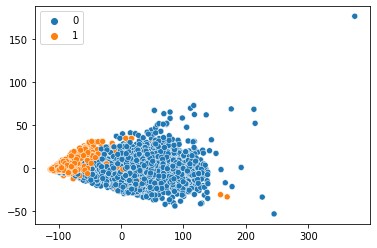

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
wineNew_PCA = pca.fit_transform(wineN)
sns.scatterplot(x = wineNew_PCA[:,0], y = wineNew_PCA[:,1], hue = wine['wine_is_red'].values, data = wineNew_PCA)

In [12]:
pca.explained_variance_ratio_

array([0.95355286, 0.04062238])

Vemos no scatterplot que em sua grande maioria há duas áreas bem distintas, com 2 outliers de valor 1

A linha abaixo normaliza o dataset para que não haja um viés devido a features muito dominantes

In [13]:
wine2 = scales(wine)
wine2.head()

fixed acidity  volatile acidity  citric acid  ...   alcohol  quality  wine_is_red
0       0.173554          0.353333     0.048193  ...  0.449275      0.5          1.0
1       0.363636          0.613333     0.054217  ...  0.144928      0.5          1.0
2       0.214876          0.106667     0.295181  ...  0.362319      0.5          0.0
3       0.231405          0.100000     0.156627  ...  0.289855      0.5          0.0
4       0.280992          0.106667     0.174699  ...  0.304348      0.5          0.0

[5 rows x 13 columns]

## Divisão do dataset em treino e teste

Vamos fazer um train_test_split manual. Para isso, conforme explicado na playlist sobre tópicos em machine learning, basta randomizar as amostras e depois tomar uma percentagem específica

In [14]:
def ttsplit(df, labelColumn, ratio = 0.2):
  shuffled = df.sample(frac=1)
  shuffled.head()
  size = np.shape(shuffled)
  train = shuffled[:round((1-ratio)*size[0])]
  test = shuffled[round((1-ratio)*size[0]):]
  X_train = train.drop(columns = labelColumn).reset_index( drop = True)
  X_test = test.drop(columns = labelColumn).reset_index(drop = True)
  y_train = train[labelColumn].reset_index( drop = True)
  y_test = test[labelColumn].reset_index(drop = True)
  return X_train, X_test, y_train, y_test


In [15]:
init = time.time()
X_train, X_test, y_train, y_test = ttsplit(wine2, 'wine_is_red')
#np.shape(y_train)
print(time.time()-init)
X_test.head()

0.007965326309204102


fixed acidity  volatile acidity  citric acid  ...  sulphates   alcohol   quality
0       0.247934          0.120000     0.289157  ...   0.129213  0.202899  0.500000
1       0.272727          0.160000     0.144578  ...   0.151685  0.115942  0.333333
2       0.264463          0.053333     0.150602  ...   0.134831  0.173913  0.500000
3       0.231405          0.280000     0.024096  ...   0.235955  0.202899  0.500000
4       0.223140          0.113333     0.301205  ...   0.129213  0.173913  0.333333

[5 rows x 12 columns]

## Implementando o KNN

A função abaixo retorna os índices no dataframe dos k vizinhos mais próximos


In [16]:
def neighbours (X_train, x, k = 5):
  dist = np.sqrt(np.sum((X_train-x)**2, axis=1)) 
  neigh = np.argsort(dist)[0:k]
  return neigh.values

In [17]:
neighbours(X_train, X_test.iloc[0])

array([3377, 2418, 2748, 3353,  545])

In [18]:
def kNN(point, dataset, labels,k = 5):
  nn = neighbours(dataset, point)
  #print(nn , '\n')
  votes = labels.iloc[nn]
  #print(votes , '\n')
  counts = np.bincount(votes)
  #print(counts , '\n')
  return np.argmax(counts)

## Caso binário

In [19]:
results = []
R,C = np.shape(X_test)
init = time.time()
for i in range(R):
  results.append(kNN(X_test.iloc[i], X_train, y_train))
print(time.time()-init)

5.094929218292236


In [20]:
N = np.shape(y_test)
accuracy = (y_test == results).sum() / N
accuracy

array([0.98845266])

Vemos que a acurácia é de 99% em média. Vamos comparar com a acurácia do kNN nativo ao sklearn

In [21]:
model = KNeighborsClassifier(n_neighbors=5)
init = time.time()
model.fit(X_train,y_train)
y_pred= model.predict(X_test) 
print(time.time()-init)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

0.11859726905822754
Accuracy: 0.9884526558891455


## KNN com múltiplos labels

In [22]:
wine2['quality'] = quality
X_train, X_test, y_train, y_test = ttsplit(wine2, 'quality')


As duas linhas de código abaixo foram escritas para ver se o dataset estava funcionando bem com instâncias específicas.

In [23]:
y_train.head()

0    6
1    6
2    5
3    5
4    7
Name: quality, dtype: int64

In [24]:
kNN(X_test.iloc[i], X_train, y_train)

5

In [25]:
results = []
R,C = np.shape(X_test)
init = time.time()
for i in range(R):
  results.append(kNN(X_test.iloc[i], X_train, y_train))
print(time.time()-init)

5.195952415466309


In [26]:
N = np.shape(y_test)
accuracy = (y_test == results).sum() / N
accuracy

array([0.58583526])

In [27]:
model = KNeighborsClassifier(n_neighbors=5)
init = time.time()
model.fit(X_train,y_train)
y_pred= model.predict(X_test) 
print(time.time()-init)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

0.12468290328979492
Accuracy: 0.5858352578906851


Como podemos ver, a acurácia não é particularmente boa. Isso se deve ao fato, como podemos ver no gráfico abaixo, que não há uma clara divisão espacial entre as classes. De fato, parece um caso que a expertise do profissional não é tão facilmente substituída assim.

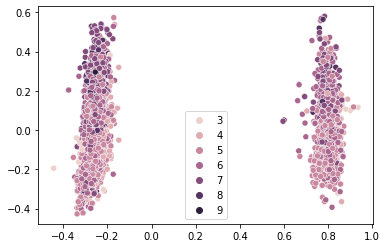

In [29]:
wineNew_PCA = pca.fit_transform(wine.drop(columns = ['quality']))
sns.scatterplot(x = wineNew_PCA[:,0], y = wineNew_PCA[:,1], hue = wine2['quality'].values, data = wineNew_PCA)

## Random forest: Determinando a importância das features

Artigo base https://vitalflux.com/feature-importance-random-forest-classifier-python/:

In [31]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train.values.ravel())

RandomForestClassifier()

In [32]:
importances = forest.feature_importances_
importances

array([0.07528222, 0.09939671, 0.07757322, 0.08493427, 0.08802145,
       0.08631976, 0.092489  , 0.10070604, 0.08173424, 0.08540828,
       0.12443457, 0.00370025])

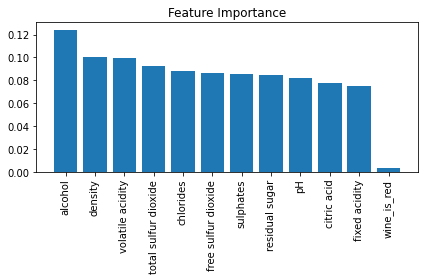

In [34]:
sorted_indices = np.argsort(importances)[::-1]
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Acima podemos ver que a característica mais importante para determinar a qualidade de um binho é seu teor alcóolico, contando por mais de 12% da influência. O que tem menos influência é se o vinho é tinto ou não.

##Sampling

A fazer

## Ensemble Learning

A fazer